In [1]:
import csv
import os
import re
from datetime import datetime

import bert
import nltk
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.tokenize import word_tokenize
from official.nlp import optimization
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tqdm import tqdm

In [2]:
# Include this block so that keras 
# # would not use up all the GPU memory.
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
OUTPUT_DIR = './model/'
datafiles_path = './data/drug_features_classification.csv'
data_files = pd.read_csv(datafiles_path)

In [5]:
labels = ["CHARGE","TYPE_DRUGS","QUANTITY_DRUGS","QUANTITY_DRUGS_TOTAL",
"REFUGEE","REFUGEE_SENT","BAIL","BAIL_SENT","STREET","STREET_SENT","PERSISTENT","PERSISTENT_SENT","INTERNATIONAL","INTERNATIONAL_SENT","AGGREV_OTHER","AGGREV_OTHER_SENT",
"INDIVIDUAL_PENALTY","ALL_PENALTY","TRAINING_CENTER","DETENTION_CENTER","ADDICTION_TREATMENT_CENTER",
"PLEA_NOT_GUILTY","PLEA_GUILTY",
"REMORSE","REMORSE_SENT","SELF_CONSUME","SELF_CONSUME_SENT","CONTROLLED","CONTROLLED_SENT","TESTIMONY","TESTIMONY_SENT","GOOD_CHARACTER","GOOD_CHARACTER_SENT","MITIG_OTHER","MITIG_OTHER_SENT",
"YOUTH","PREVIOUS_CRIMINAL","CLEAR_RECORD","DRUG_ADDICT",
"STARTING_TARIFF","STARTING_TARIFF_COMBINED"]
data_files

,neutral_citation,sentence_id,sentence,CHARGE,TYPE_DRUGS,QUANTITY_DRUGS,QUANTITY_DRUGS_TOTAL,REFUGEE,REFUGEE_SENT,BAIL,...,GOOD_CHARACTER,GOOD_CHARACTER_SENT,MITIG_OTHER,MITIG_OTHER_SENT,YOUTH,PREVIOUS_CRIMINAL,CLEAR_RECORD,DRUG_ADDICT,STARTING_TARIFF,STARTING_TARIFF_COMBINED
0,[2009] HKCFI 2104,0,"## HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[2009] HKCFI 2104,1,HCCC241/2008,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[2009] HKCFI 2104,2,IN THE HIGH COURT OF THE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[2009] HKCFI 2104,3,HONG KONG SPECIAL ADMINISTRATIVE REGION,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[2009] HKCFI 2104,4,COURT OF FIRST INSTANCE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298697,[2012] HKCFI 795,17,"In my view, the appropriate starting point sho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
298698,[2012] HKCFI 795,18,Having considered everything urged in mitigati...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298699,[2012] HKCFI 795,19,In all the circumstances and bearing in mind t...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298700,[2012] HKCFI 795,20,To achieve that overall I sentence you to 3 ye...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Clean up the data

#Function to clean up data
#•Only take characters inside A-Za-z
#•remove stop words
#•lemmatize

In [8]:
def cleanUpSentence(r):
    strip_special_chars = re.compile("[^A-Za-z0-9, ]+")
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    words = word_tokenize(r)
    filtered_sentence = []
    for w in words:
        if any(map(str.isdigit, w)):
            filtered_sentence.append("0")
        elif w:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence),len(filtered_sentence)

In [9]:
def clean_data(datas_X):    
    totalX = []
    maxLength = 0
    with tqdm(total=datas_X.shape[0], unit_scale=True) as pbar:
        for i, doc in enumerate(datas_X):
            #直接在这里去除\n，防止\n可能会让两句话连接处的两个单词连在一起
            doc = doc.replace("\n"," ")
            sent,sent_len = cleanUpSentence(doc)
            maxLength = max(maxLength,sent_len)
            totalX.append(sent)
            pbar.update()
    print("max input length is: ",maxLength)
    totalX=np.array(totalX)
    return totalX,maxLength

In [10]:
def preprocess(data_df,train_frac=0.8,neg_resample_frac=0.25):
    totalX,maxLength = clean_data(data_df['sentence'])
    empty_pred = data_files[totalX==''].reset_index(drop=True)
    for label in labels:
        empty_pred[label] = [0] * empty_pred.shape[0]
    total_df = data_files[totalX!=''][['neutral_citation','sentence_id']].reset_index(drop=True)
    total_df['X'],total_df[labels] = totalX[totalX!=''],data_files[totalX!=''][labels].values.astype(int)
    pos_df,neg_df = total_df[total_df[labels].any(axis=1)],total_df[~total_df[labels].any(axis=1)]
    print("positive sample size: ", pos_df.shape[0])
    train_pos,test_pos = train_test_split(pos_df,train_size=train_frac,random_state=1)
    train_neg,test_neg = train_test_split(neg_df,train_size=train_frac*neg_resample_frac,random_state=1)
    train_df = train_pos.append(train_neg).sample(frac=1).reset_index(drop=True)
    test_df = test_pos.append(test_neg).sample(frac=1).reset_index(drop=True)
    return empty_pred,total_df,train_df,test_df,maxLength

In [11]:
empty_pred,total_df,train_df,test_df,maxLength = preprocess(data_files,neg_resample_frac=1)
train_df

100%|██████████| 299k/299k [00:44<00:00, 6.78kit/s] 


max input length is:  267
positive sample size:  33830


,neutral_citation,sentence_id,X,CHARGE,TYPE_DRUGS,QUANTITY_DRUGS,QUANTITY_DRUGS_TOTAL,REFUGEE,REFUGEE_SENT,BAIL,...,GOOD_CHARACTER,GOOD_CHARACTER_SENT,MITIG_OTHER,MITIG_OTHER_SENT,YOUTH,PREVIOUS_CRIMINAL,CLEAR_RECORD,DRUG_ADDICT,STARTING_TARIFF,STARTING_TARIFF_COMBINED
0,[2018] HKDC 579,113,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[2015] HKDC 332,17,0 opened the door,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[2011] HKDC 1850,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[2010] HKDC 1318,45,trafficking in dangerous drugs is a serious of...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[2016] HKCFI 1918,19,you were therefore arrested and taken to the s...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212904,[2015] HKDC 2,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212905,[2016] HKDC 1024,59,i believe that would place it in the region of...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
212906,[2015] HKDC 1541,26,0 she had purchased the electronic scale for w...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212907,[2013] HKCA 630,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
empty_pred

,neutral_citation,sentence_id,sentence,CHARGE,TYPE_DRUGS,QUANTITY_DRUGS,QUANTITY_DRUGS_TOTAL,REFUGEE,REFUGEE_SENT,BAIL,...,GOOD_CHARACTER,GOOD_CHARACTER_SENT,MITIG_OTHER,MITIG_OTHER_SENT,YOUTH,PREVIOUS_CRIMINAL,CLEAR_RECORD,DRUG_ADDICT,STARTING_TARIFF,STARTING_TARIFF_COMBINED
0,[2009] HKCFI 2104,6,> \----------------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[2009] HKCFI 2104,8,> \----------------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[2009] HKCFI 2105,6,> \----------------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[2009] HKCFI 2105,8,> \----------------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[2009] HKCFI 2105,42,>,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32560,[2012] HKCFI 1705,59,>,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32561,[2012] HKCFI 795,6,\-----------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32562,[2012] HKCFI 795,8,\-----------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32563,[2012] HKCFI 795,10,\---------------------------------,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for label in labels:
    feature_set = train_df[label].values
    print(label,feature_set[feature_set==1].shape[0])

CHARGE 3476
TYPE_DRUGS 3884
QUANTITY_DRUGS 3857
QUANTITY_DRUGS_TOTAL 164
REFUGEE 78
REFUGEE_SENT 53
BAIL 96
BAIL_SENT 30
STREET 0
STREET_SENT 0
PERSISTENT 194
PERSISTENT_SENT 95
INTERNATIONAL 1082
INTERNATIONAL_SENT 580
AGGREV_OTHER 157
AGGREV_OTHER_SENT 83
INDIVIDUAL_PENALTY 3565
ALL_PENALTY 603
TRAINING_CENTER 66
DETENTION_CENTER 1379
ADDICTION_TREATMENT_CENTER 9
PLEA_NOT_GUILTY 226
PLEA_GUILTY 3417
REMORSE 292
REMORSE_SENT 14
SELF_CONSUME 588
SELF_CONSUME_SENT 258
CONTROLLED 84
CONTROLLED_SENT 15
TESTIMONY 76
TESTIMONY_SENT 8
GOOD_CHARACTER 60
GOOD_CHARACTER_SENT 12
MITIG_OTHER 732
MITIG_OTHER_SENT 197
YOUTH 20
PREVIOUS_CRIMINAL 3958
CLEAR_RECORD 905
DRUG_ADDICT 928
STARTING_TARIFF 4119
STARTING_TARIFF_COMBINED 0


In [14]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_all_sentences(sentences, tokenizer, max_seq_len=20):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    with tqdm(total=sentences.shape[0], unit_scale=True) as pbar:
        for sentence in sentences:
            input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
            all_input_ids.append(input_ids)
            all_input_mask.append(input_mask)
            all_segment_ids.append(segment_ids)
            pbar.update()
    return np.array(all_input_ids), np.array(all_input_mask), np.array(all_segment_ids)

In [15]:
VOCAB_FILE = 'bert_uncased_L-12_H-768_A-12/assets/vocab.txt'

BertTokenizer = bert.bert_tokenization.FullTokenizer(VOCAB_FILE,do_lower_case=True)
train_input_ids, train_input_mask, train_segment_ids = convert_all_sentences(train_df['X'], 
                                                                            BertTokenizer, 
                                                                            max_seq_len=maxLength)
test_input_ids, test_input_mask, test_segment_ids = convert_all_sentences(test_df['X'], 
                                                                        BertTokenizer, 
                                                                        max_seq_len=maxLength)

100%|██████████| 213k/213k [01:18<00:00, 2.70kit/s] 
100%|██████████| 53.2k/53.2k [00:14<00:00, 3.60kit/s]


In [16]:
#Create Keras model
#num_categories 总标签数
num_categories = len(labels)
DROPOUT = 0.1
MODEL_PATH = "bert_uncased_L-12_H-768_A-12"

def create_bert_classifier(max_seq_len):
    input_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_ids')
    input_mask = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='segment_ids')
    bert_inputs = dict(
        input_word_ids=input_ids,
        input_mask=input_mask,
        input_type_ids=segment_ids)
    bert_model = hub.KerasLayer(MODEL_PATH, name="bert", trainable=True)
    net = bert_model(bert_inputs)["pooled_output"]
    net = Dropout(DROPOUT, name="dropout")(net)
    net = Dense(num_categories, activation='sigmoid', name="logistic_output")(net)
    return tf.keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=net)


In [ ]:
%%capture train

BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_PROPORTION = 0.1

num_train_steps = int(train_df.shape[0]*0.8 / BATCH_SIZE * EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

trainX = {
    "input_ids": train_input_ids,
    "input_mask": train_input_mask,
    "segment_ids": train_segment_ids
}
trainY = train_df[labels].values
testX = {
    "input_ids": test_input_ids,
    "input_mask": test_input_mask,
    "segment_ids": test_segment_ids
}
testY = test_df[labels].values
#     print(data_files.loc[total_idx.iloc[test_index].index][['neutral_citation','sentence_id']])

with strategy.scope():
    model = create_bert_classifier(maxLength)
    optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                      num_train_steps=num_train_steps,
                                      num_warmup_steps=num_warmup_steps,
                                      optimizer_type='adamw')

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])    

history = model.fit(trainX, 
                    trainY, 
                    validation_split=0.1, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS)

print(model.evaluate(testX, testY, batch_size=BATCH_SIZE))
pred_df = pd.DataFrame(model.predict(testX),columns=labels)
pred_df[['neutral_citation','sentence_id']] = test_df[['neutral_citation','sentence_id']].values

saved_model_path = './model/bert_features '+str(datetime.now())
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0', '/device:GPU:1')
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CollectiveCommunication.AUTO
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 200 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_red

In [ ]:
%%capture charts

import matplotlib.pyplot as plt
    
plt.figure()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

In [27]:
correct = 0
incorrect = 0
precision = []
recall = []
for label in labels:    
    conmax = sklearn.metrics.confusion_matrix(test_df[label], np.array(pred_df[label]>0.5).astype(int))
    print("Confusion Matrix for: ", label)
    classes = conmax.ravel()
    if len(classes) == 1:
        print("Not enough data")
        print("--------------------------------")
        continue
    tn, fp, fn, tp = classes
    correct += tn + tp
    incorrect += fn + fp
    print("""
                    predicted false  predicted true
    labeled false       {0: >5}           {1: >5} 
    labeled true        {2: >5}           {3: >5} 
    """.format(tn, fp, fn, tp))
    print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
    print("Positive: " + str(tp+fn))
    print("Precision: " + str(round(tp/(tp+fp), 2)))
    print("Recall: " + str(round(tp/(tp+fn), 2)))
    pre,rec = tp/(tp+fp), tp/(tp+fn)
    print("F1: {}".format(round(2*pre*rec/(pre+rec), 4)))
    precision.append(pre)
    recall.append(rec)
    print("--------------------------------")

print("Summary:")
print("Accuracy: {}".format(correct/(correct+incorrect)))
ap = np.mean(precision)
ar = np.mean(recall)
print("Precision: {}".format(round(ap, 4)))
print("Recall: {}".format(round(ar, 4)))
print("F1: {}".format(round(2*ap*ar/(ap+ar), 4)))

Confusion Matrix for:  CHARGE

                    predicted false  predicted true
    labeled false       52295              48 
    labeled true           57             828 
    
Accuracy: 0.9980273540241978
Positive: 885
Precision: 0.95
Recall: 0.94
F1: 0.9404
--------------------------------
Confusion Matrix for:  TYPE_DRUGS

                    predicted false  predicted true
    labeled false       52098             188 
    labeled true          234             708 
    
Accuracy: 0.9920718418877282
Positive: 942
Precision: 0.79
Recall: 0.75
F1: 0.7704
--------------------------------
Confusion Matrix for:  QUANTITY_DRUGS

                    predicted false  predicted true
    labeled false       52078             202 
    labeled true          217             731 
    
Accuracy: 0.9921282032013227
Positive: 948
Precision: 0.78
Recall: 0.77
F1: 0.7772
--------------------------------
Confusion Matrix for:  QUANTITY_DRUGS_TOTAL

                    predicted false  predicted tr

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  REFUGEE_SENT

                    predicted false  predicted true
    labeled false       53219               0 
    labeled true            9               0 
    
Accuracy: 0.9998309160592169
Positive: 9
Precision: nan
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  BAIL

                    predicted false  predicted true
    labeled false       53189               3 
    labeled true           35               1 
    
Accuracy: 0.9992860900278049
Positive: 36
Precision: 0.25
Recall: 0.03
F1: 0.05
--------------------------------
Confusion Matrix for:  BAIL_SENT

                    predicted false  predicted true
    labeled false       53222               0 
    labeled true            6               0 
    
Accuracy: 0.9998872773728114
Positive: 6
Precision: nan
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  STREET

                    predicted false  predicted true
    labeled false       53227    

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Confusion Matrix for:  STREET_SENT
Not enough data
--------------------------------
Confusion Matrix for:  PERSISTENT

                    predicted false  predicted true
    labeled false       53167               5 
    labeled true           42              14 
    
Accuracy: 0.9991170060870219
Positive: 56
Precision: 0.74
Recall: 0.25
F1: 0.3733
--------------------------------
Confusion Matrix for:  PERSISTENT_SENT

                    predicted false  predicted true
    labeled false       53200               2 
    labeled true           26               0 
    
Accuracy: 0.9994739610731194
Positive: 26
Precision: 0.0
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  INTERNATIONAL

                    predicted false  predicted true
    labeled false       52795             153 
    labeled true           94             186 
    
Accuracy: 0.995359585180732
Positive: 280
Precision: 0.55
Recall: 0.66
F1: 0.601
--------------------------------
Confusion M

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  ALL_PENALTY

                    predicted false  predicted true
    labeled false       53007              82 
    labeled true           56              83 
    
Accuracy: 0.99740737957466
Positive: 139
Precision: 0.5
Recall: 0.6
F1: 0.5461
--------------------------------
Confusion Matrix for:  TRAINING_CENTER

                    predicted false  predicted true
    labeled false       53214               3 
    labeled true            5               6 
    
Accuracy: 0.9998497031637484
Positive: 11
Precision: 0.67
Recall: 0.55
F1: 0.6
--------------------------------
Confusion Matrix for:  DETENTION_CENTER

                    predicted false  predicted true
    labeled false       52750             121 
    labeled true          150             207 
    
Accuracy: 0.9949086946719772
Positive: 357
Precision: 0.63
Recall: 0.58
F1: 0.6044
--------------------------------
Confusion Matrix for:  ADDICTION_TREATMENT_CENTER

                    predicted false  pr

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  PLEA_NOT_GUILTY

                    predicted false  predicted true
    labeled false       53151              18 
    labeled true           18              41 
    
Accuracy: 0.9993236642368678
Positive: 59
Precision: 0.69
Recall: 0.69
F1: 0.6949
--------------------------------
Confusion Matrix for:  PLEA_GUILTY

                    predicted false  predicted true
    labeled false       52146             267 
    labeled true          297             518 
    
Accuracy: 0.9894040730442624
Positive: 815
Precision: 0.66
Recall: 0.64
F1: 0.6475
--------------------------------
Confusion Matrix for:  REMORSE

                    predicted false  predicted true
    labeled false       53138              33 
    labeled true           28              29 
    
Accuracy: 0.9988539866235816
Positive: 57
Precision: 0.47
Recall: 0.51
F1: 0.4874
--------------------------------
Confusion Matrix for:  REMORSE_SENT

                    predicted false  predicted true
    

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  SELF_CONSUME

                    predicted false  predicted true
    labeled false       53017              52 
    labeled true          100              59 
    
Accuracy: 0.9971443601112197
Positive: 159
Precision: 0.53
Recall: 0.37
F1: 0.437
--------------------------------
Confusion Matrix for:  SELF_CONSUME_SENT

                    predicted false  predicted true
    labeled false       53138              13 
    labeled true           38              39 
    
Accuracy: 0.9990418576688961
Positive: 77
Precision: 0.75
Recall: 0.51
F1: 0.6047
--------------------------------
Confusion Matrix for:  CONTROLLED

                    predicted false  predicted true
    labeled false       53208               2 
    labeled true           14               4 
    
Accuracy: 0.9996994063274968
Positive: 18
Precision: 0.67
Recall: 0.22
F1: 0.3333
--------------------------------
Confusion Matrix for:  CONTROLLED_SENT

                    predicted false  predicted t

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  TESTIMONY

                    predicted false  predicted true
    labeled false       53212               0 
    labeled true           16               0 
    
Accuracy: 0.9996994063274968
Positive: 16
Precision: nan
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  TESTIMONY_SENT

                    predicted false  predicted true
    labeled false       53226               0 
    labeled true            2               0 
    
Accuracy: 0.9999624257909371
Positive: 2
Precision: nan
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  GOOD_CHARACTER

                    predicted false  predicted true
    labeled false       53211               0 
    labeled true           16               1 
    
Accuracy: 0.9996994063274968
Positive: 17
Precision: 1.0
Recall: 0.06
F1: 0.1111
--------------------------------
Confusion Matrix for:  GOOD_CHARACTER_SENT

                    predicted false  predicted true
    la

/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix for:  MITIG_OTHER

                    predicted false  predicted true
    labeled false       52996              31 
    labeled true          163              38 
    
Accuracy: 0.9963553017208988
Positive: 201
Precision: 0.55
Recall: 0.19
F1: 0.2815
--------------------------------
Confusion Matrix for:  MITIG_OTHER_SENT

                    predicted false  predicted true
    labeled false       53151              18 
    labeled true           28              31 
    
Accuracy: 0.9991357931915533
Positive: 59
Precision: 0.63
Recall: 0.53
F1: 0.5741
--------------------------------
Confusion Matrix for:  YOUTH

                    predicted false  predicted true
    labeled false       53224               0 
    labeled true            4               0 
    
Accuracy: 0.9999248515818742
Positive: 4
Precision: nan
Recall: 0.0
F1: nan
--------------------------------
Confusion Matrix for:  PREVIOUS_CRIMINAL

                    predicted false  predicted true
    la

In [ ]:
pred_df.to_csv('output/bert_features_{}.csv'.format(str(datetime.now())), index=False)

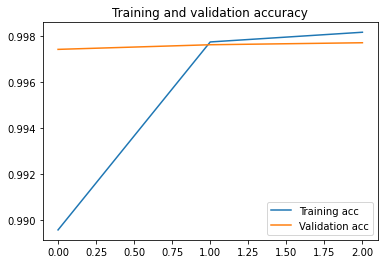

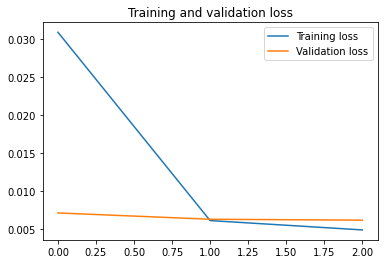

In [24]:
charts.show()

In [25]:
train.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 200 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
INFO:tensorflow:Collective batch_all_reduce: 1 all-redu

In [ ]:
import csv
with open('output/extracted_importance_bert_features.csv', 'w') as ofile:
    csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
    csv_writer.writerow(list(data_files.columns)[:-1])
    for idx, predict in zip(prediction_index, prediction):
        csv_writer.writerow(idx + list(predict>0.5))
# empty_pred.to_csv('output/extracted_importance_bert_resample.csv', mode='a', header=False, index=False)